In [34]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import folium
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import statsmodels.api as sm
from sklearn import metrics
import datetime
from statsmodels.graphics.tsaplots import plot_pacf

<p> Data Uploads and Cleaning </p>

In [4]:
data = pd.read_csv('./assets/main.csv')
death_data = pd.read_csv('./assets/deaths.csv')

In [8]:
confirmed_data = pd.read_csv('./assets/Confirmed_time.csv')

In [9]:
confirmed_data.set_index('variable', inplace=True)

In [10]:
confirmed_data['Totals'] = confirmed_data.sum(axis=1)

In [ ]:
melt = pd.melt(data, id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
melt['variable'] = pd.to_datetime(melt['variable'], infer_datetime_format=True)
melt.set_index('variable', inplace=True)

In [11]:
death_data.set_index('variable',inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.set_index('variable', inplace=True)

In [12]:
last_deaths = death_data.iloc[-1:]
death_cols = list(last_deaths.columns)
death_nums = [i for i in last_deaths.iloc[-1]]
graphing_df = pd.DataFrame({'States':death_cols, 'Deaths':death_nums})
graphing_df.drop([0,1,2,3,4,13,56,57], inplace=True)

In [14]:
graphing_df['States'] = [i.replace('_', ' ') for i in graphing_df['States']]

In [15]:
death_data['Totals'] = death_data.sum(axis=1)

##### Death Statistics

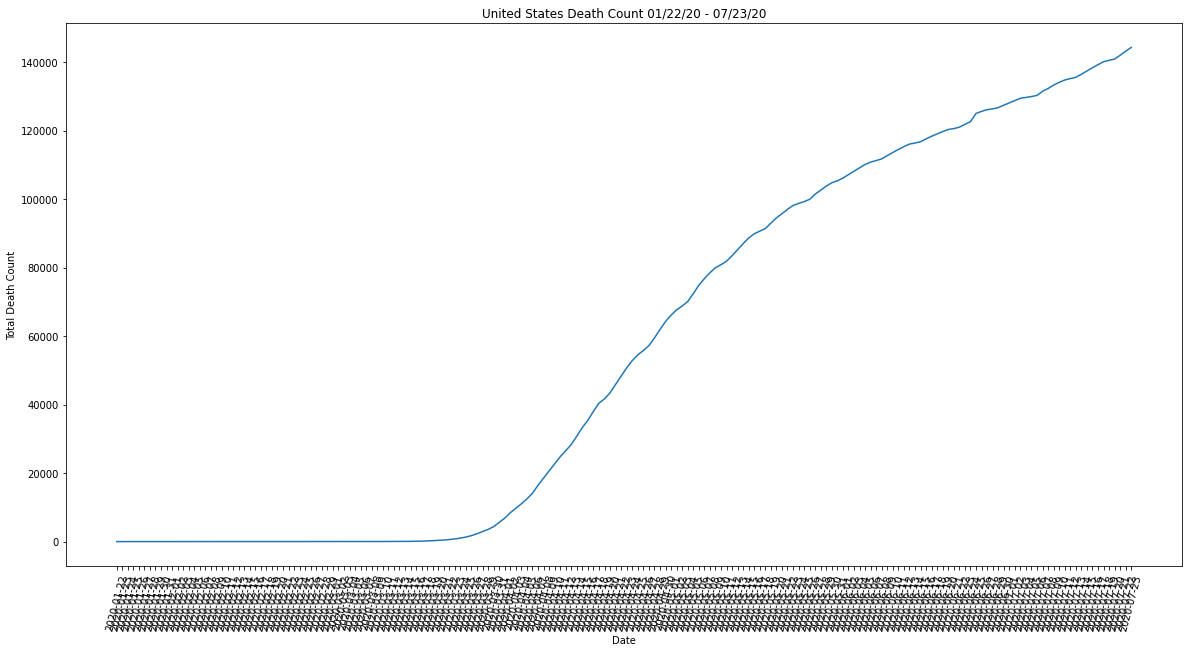

In [16]:
plt.figure(figsize=(20,10))
death_chart = sns.lineplot(x=death_data.index,y=death_data['Totals']).set_xticklabels(labels=death_data.index,rotation=75)
plt.xlabel('Date')
plt.ylabel('Total Death Count')
plt.title('United States Death Count 01/22/20 - 07/23/20')
plt.show()

<p> The current date rate is increasing exponentially. <p>

In [17]:
print("Is the data stationary ?")
dftest = adfuller(death_data['Totals'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Is the data stationary ?
Test statistic = -0.252
P-value = 0.932
Critical values :
	1%: -3.468952197801766 - The data is not stationary with 99% confidence
	5%: -2.878495056473015 - The data is not stationary with 95% confidence
	10%: -2.57580913601947 - The data is not stationary with 90% confidence


<p> Based on our Dickey-Fuller Test, we have additional proof that the time series is not stationary. </p>

In [18]:
ind = death_data.index
test_df = pd.DataFrame([death_data['Totals']])
test_df = test_df.T

In [19]:
test_df.index=pd.to_datetime(test_df.index)

<p> Resampling the data </p>

In [122]:
weekly_rates = test_df.resample('w').mean()
monthly_rates = test_df.resample('m').mean()

[Text(0, 0, '2020-01-31 00:00:00'),
 Text(0, 0, '2020-02-29 00:00:00'),
 Text(0, 0, '2020-03-31 00:00:00'),
 Text(0, 0, '2020-04-30 00:00:00'),
 Text(0, 0, '2020-05-31 00:00:00'),
 Text(0, 0, '2020-06-30 00:00:00'),
 Text(0, 0, '2020-07-31 00:00:00')]

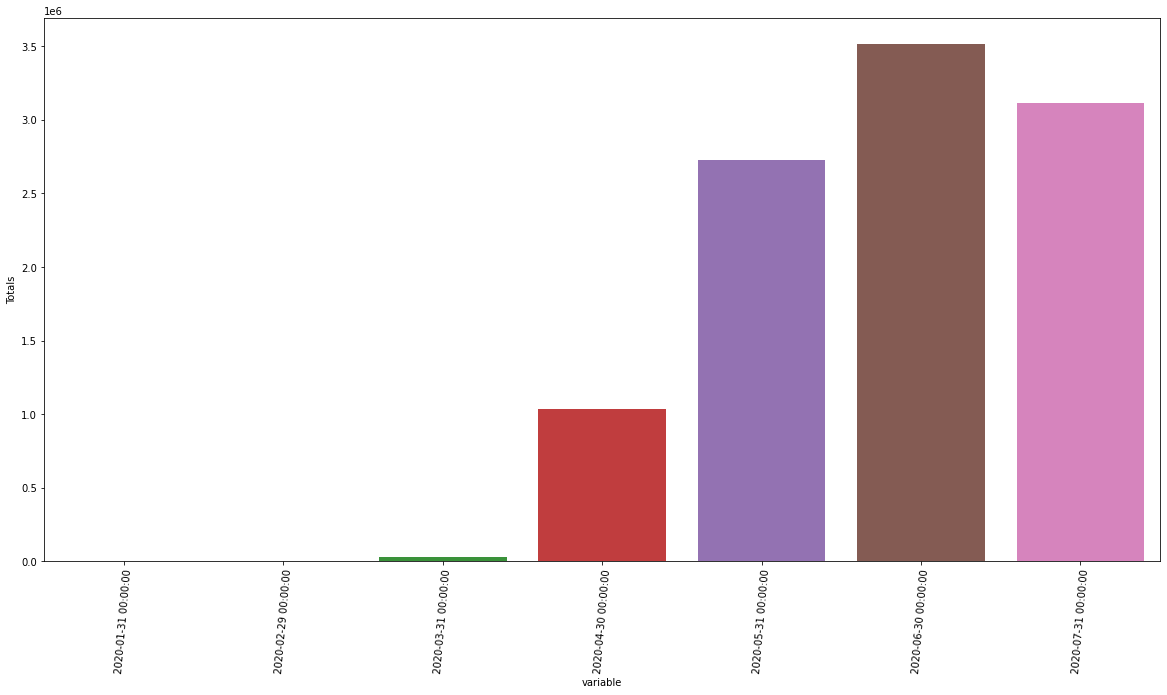

In [24]:
plt.figure(figsize=(20,10))
monthly_data = sns.barplot(x=monthly_rates.index, y=monthly_rates['Totals'])
monthly_data.set_xticklabels(labels=monthly_rates.index, rotation=85)

In [204]:
graphing_df['States'] = [i.replace('_', ' ') for i in graphing_df['States']]

In [361]:
graphing_df = new_df
graphing_df.reset_index(inplace=True)

In [601]:
state_data.index[-5:]

Index(['Missouri', 'Kentucky', 'Virginia', 'Georgia', 'Texas'], dtype='object', name='Province_State')

##### Confirmed Cases

Text(0.5, 1.0, 'Top 10 States with Confirmed Cases')

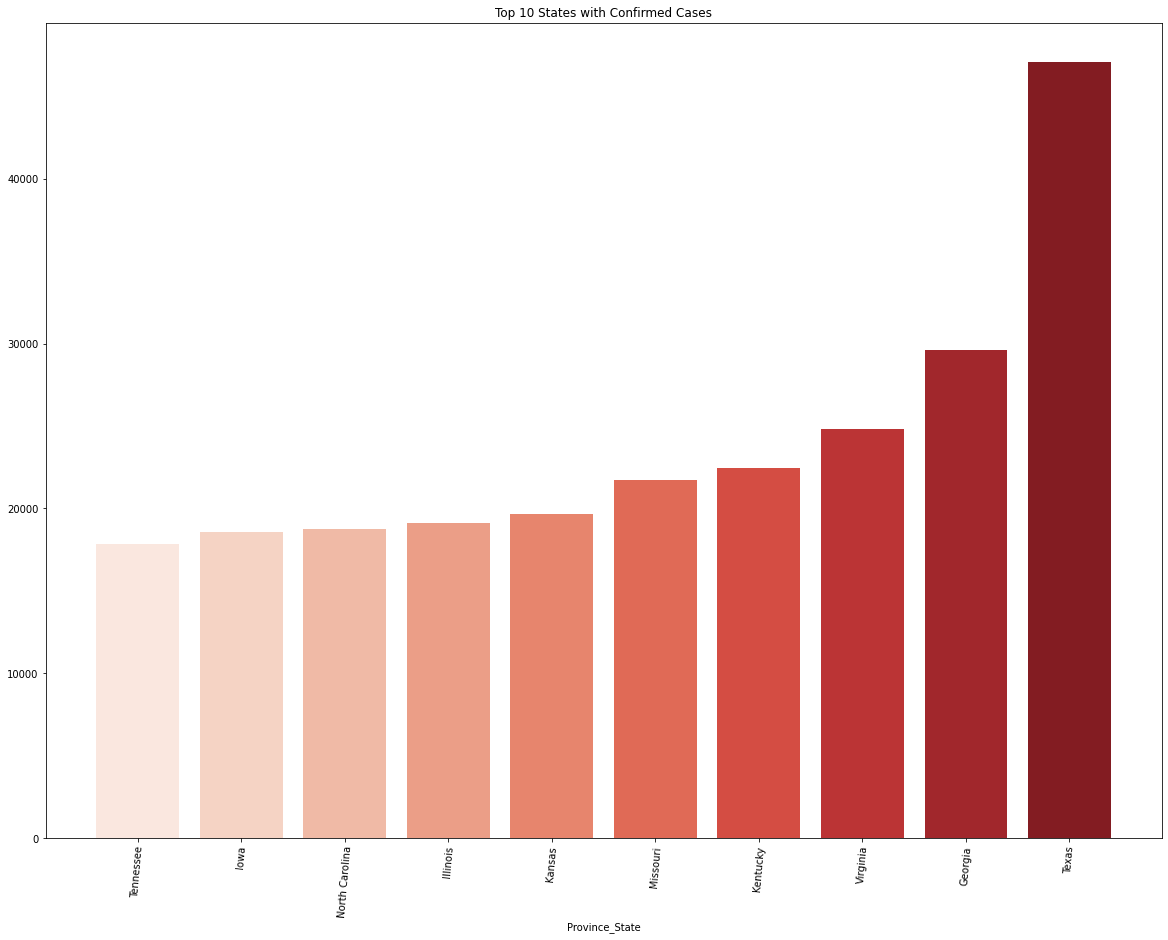

In [603]:
plt.figure(figsize=(20,15))
state_chart = sns.barplot(x=state_data.index[-10:], y=state_data.values[-10:] ,orient='v', palette='Reds')
state_chart.set_xticklabels(labels=state_data.index[-10:], rotation=85)
state_chart.plot()
plt.title('Top 10 States with Confirmed Cases')

### Modeling

<p> Modeling death totals </p>

In [607]:
death_data.diff()

,American_Samoa,Guam,Northern_Mariana_Islands,Puerto_Rico,Virgin_Islands,Alabama,Alaska,Arizona,Arkansas,California,...,Utah,Vermont,Virginia,Washington,West_Virginia,Wisconsin,Wyoming,Diamond_Princess,Grand_Princess,Totals
variable,,,,,,,,,,,,,,,,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [608]:
def setting_index(x):
    x.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'],inplace=True,axis=1)
    x.set_index(['variable'],inplace=True)
    return pd.DataFrame(x.resample('D').sum())

## ARIMA - Models

## SARIMAX - Death

In [137]:
death_total = pd.DataFrame(death_data['Totals'])

### Differencing data in order to achieve stationarity.

death_total_diff1= death_total.diff()
death_total_diff2=death_total_diff1.diff()
dt_diff3 = death_total_diff2.diff()

In [166]:
def differencing(dataframe, num):
    data = pd.DataFrame(dataframe)
    data['Totals'] = dataframe.diff(periods=num)
    return data

In [167]:
diff_data = differencing(death_data['Totals'], 2)

In [183]:
def sarimax_model(dataframe, p,d,q):
    ans = {}
    test_dates = '2020-07-09'
    training_dates_start = '2020-03-10'
    training_dates_end = '2020-07-08'

    testing_set_values = dataframe[test_dates:]
    testing_set = dataframe[test_dates:].drop('Totals', axis=1)
    training_set = dataframe[training_dates_start:training_dates_end]
    
    mod = sm.tsa.statespace.SARIMAX(dataframe['Totals'], trend='c', order=(int(p),int(d),int(q)))
    res = mod.fit(disp=False)
    preds = res.predict()
    ans['Results'] = res.summary()
    ans['RMSE'] = np.sqrt(metrics.mean_squared_error(training_set,preds))
            
    return ans
    

In [184]:
sarimax_model(diff_data, 1,1,1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ValueError: Found input variables with inconsistent numbers of samples: [121, 184]

In [172]:
test_dates = '2020-07-09'
training_dates_start = '2020-03-10'
training_dates_end = '2020-07-08'

testing_set_values = dt_diff3[test_dates:]
testing_set = dt_diff3[test_dates:].drop('Totals',axis=1)
training_set = dt_diff3[training_dates_start:training_dates_end]

In [644]:
mod = sm.tsa.statespace.SARIMAX(training_set['Totals'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 Totals   No. Observations:                  121
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -923.394
Date:                Tue, 28 Jul 2020   AIC                           1854.788
Time:                        14:20:57   BIC                           1865.938
Sample:                    03-10-2020   HQIC                          1859.316
                         - 07-08-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      1.370      0.000      1.000      -2.685       2.687
ar.L1         -0.4601      0.069     -6.647      0.000      -0.596      -0.324
ma.L1         -1.0000      0.093    -10.772      0.0

<p> The results of our model shows that Δ𝑦𝑡 = 67.6713 + 0.9150Δ𝑦𝑡−1 − 0.0544𝜖𝑡−1+𝜖𝑡</p>

In [619]:
mod = sm.tsa.statespace.SARIMAX(death_total_diff2, trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 Totals   No. Observations:                  184
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1318.222
Date:                Tue, 28 Jul 2020   AIC                           2644.445
Time:                        11:52:39   BIC                           2657.283
Sample:                    01-22-2020   HQIC                          2649.649
                         - 07-23-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0896      0.447     -0.201      0.841      -0.965       0.786
ar.L1         -0.0723      0.049     -1.466      0.143      -0.169       0.024
ma.L1         -0.9999      7.048     -0.142      0.8

In [629]:
mod = sm.tsa.statespace.SARIMAX(training_set['Totals'], trend='c', order=(1,3,1))
res = mod.fit(disp=False)
print(res.summary())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Totals   No. Observations:                  121
Model:               SARIMAX(1, 3, 1)   Log Likelihood               -1009.135
Date:                Tue, 28 Jul 2020   AIC                           2026.270
Time:                        12:01:04   BIC                           2037.353
Sample:                    03-10-2020   HQIC                          2030.770
                         - 07-08-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6231      2.903     -0.215      0.830      -6.313       5.067
ar.L1         -0.7309      0.040    -18.474      0.000      -0.808      -0.653
ma.L1         -0.9999      0.089    -11.277      0.0

In [635]:
## Model Evaluation - Training Set

pred_deaths = res.predict()
np.sqrt(metrics.mean_squared_error(training_set, pred_deaths))

1225.1250134332797

In [636]:
predict_start_date = testing_set.index[0]
predict_end_date = testing_set.index[-1]

In [637]:
## Model Evaluation - Testing Set
predict = res.predict(start=predict_start_date, end=predict_end_date)

In [638]:
np.sqrt(metrics.mean_squared_error(testing_set_values, predict))

10315.865116885303

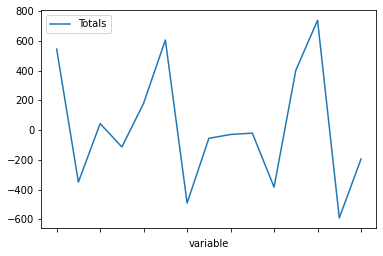

In [640]:
testing_set_values.plot()

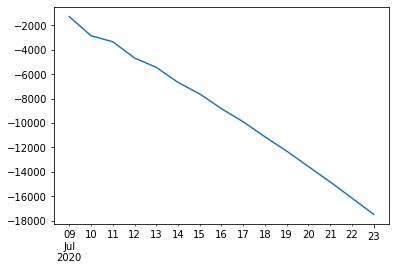

In [641]:
predict.plot()

In [622]:
mod = sm.tsa.statespace.SARIMAX(dt_diff3, trend='c', order=(1,3,1))
res = mod.fit(disp=False)
print(res.summary())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Totals   No. Observations:                  184
Model:               SARIMAX(1, 3, 1)   Log Likelihood               -1517.710
Date:                Tue, 28 Jul 2020   AIC                           3043.420
Time:                        11:55:30   BIC                           3056.214
Sample:                    01-22-2020   HQIC                          3048.607
                         - 07-23-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1025      1.223     -0.084      0.933      -2.500       2.295
ar.L1         -0.7294      0.027    -27.179      0.000      -0.782      -0.677
ma.L1         -1.0000      0.059    -16.910      0.0

In [ ]:
def sarimax_model(dataframe, p,d,q):
    ans = {}
    test_dates = '2020-07-09'
    training_dates_start = '2020-03-10'
    training_dates_end = '2020-07-08'

    testing_set_values = dataframe[test_dates:]
    testing_set = dataframe[test_dates:].drop('Totals',axis=1)
    training_set = dataframe[training_dates_start:training_dates_end]
    
    if (dataframe['Totals']):
        mod = sm.tsa.statespace.SARIMAX(dataframe['Totals'], trend='c', order=(p,d,q))
        res = mod.fit(disp=False)
        ans['Results'] = res.summary()
        ans['RMSE'] = np.sqrt(metrics.mean_squared_error(training_set, pred_deaths))
            
    return ans
    
    

In [ ]:
pred_deaths = res.predict()
np.sqrt(metrics.mean_squared_error(training_set, pred_deaths))

In [99]:
def update_date(df):
    index_list = list(df.index)
    for i in index_list:
        year = int(i[:4])
        month = int(i[5:7])
        day = int(i[8:10])
        comparision_date = datetime.datetime(year,month,day)
        check_date = datetime.datetime(2020,1,5)
        if (comparision_date < check_date):
            df['Test_col'] = True
        else:
            df['Test_col'] = False
    return df

In [79]:
before_date = datetime.date(2020,5,1)

In [104]:
death_data.drop('Test_col', axis=1, inplace=True)

In [107]:
death_data['pct_change'] = death_data['Totals'].pct_change()

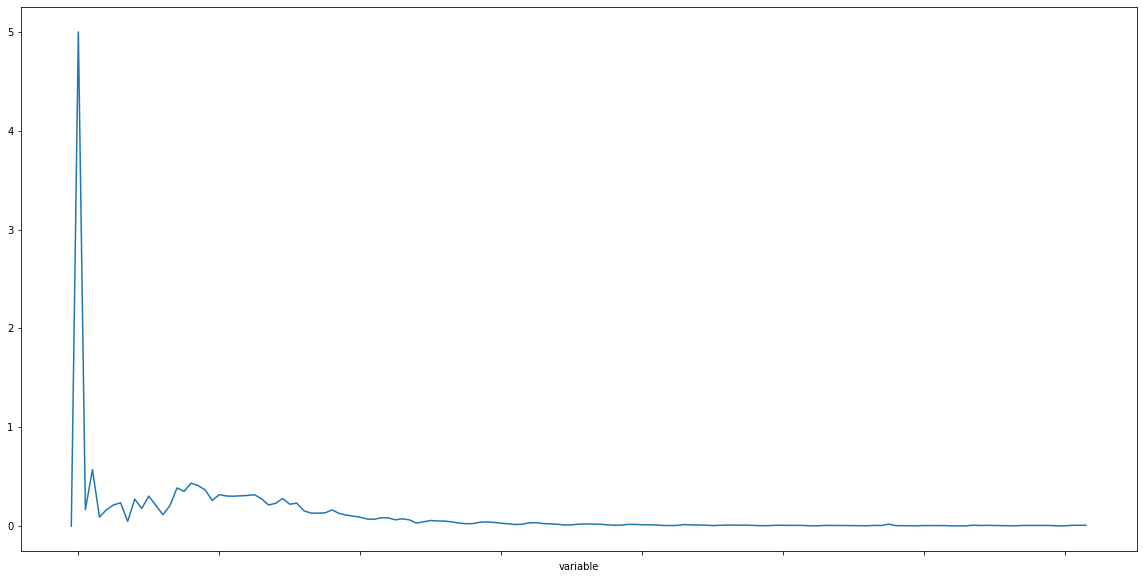

In [113]:
death_data['pct_change'].plot(figsize=(20,10))

In [123]:
weekly_rates['pct_change'] = weekly_rates['Totals'].pct_change()

In [124]:
weekly_rates.tail(10)

,Totals,pct_change
variable,,
2020-05-24,95513.285714,0.101838
2020-05-31,102467.714286,0.072811
2020-06-07,108979.571429,0.063550
2020-06-14,114347.285714,0.049254
2020-06-21,118929.571429,0.040073
2020-06-28,124085.571429,0.043353
2020-07-05,128591.714286,0.036315
2020-07-12,133062.571429,0.034768
2020-07-19,138246.285714,0.038957


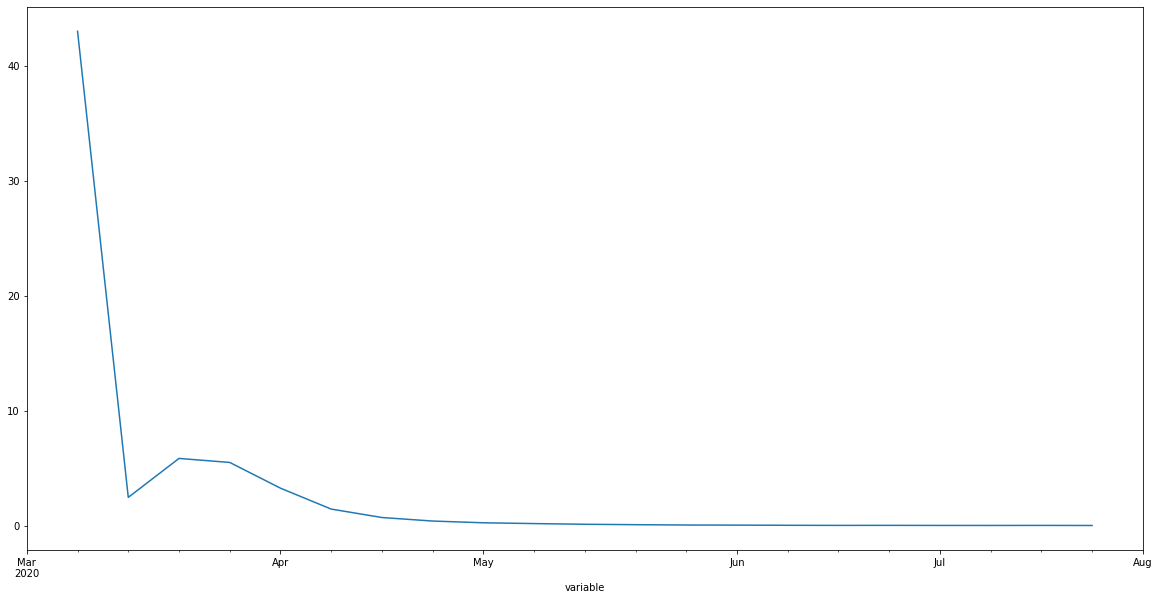

In [125]:
weekly_rates['pct_change'].plot(figsize=(20,10))

In [114]:
death_data.tail(5)

,American_Samoa,Guam,Northern_Mariana_Islands,Puerto_Rico,Virgin_Islands,Alabama,Alaska,Arizona,Arkansas,California,...,Vermont,Virginia,Washington,West_Virginia,Wisconsin,Wyoming,Diamond_Princess,Grand_Princess,Totals,pct_change
variable,,,,,,,,,,,,,,,,,,,,,
2020-07-19,0,5,2,178,6,1287,18,2761,357,7715,...,56,2027,1447,100,844,25,0,3,140534,0.002962
2020-07-20,0,5,2,180,6,1291,18,2784,363,7770,...,56,2031,1453,100,846,24,0,3,140913,0.002697
2020-07-21,0,5,2,180,6,1303,18,2918,374,7888,...,56,2048,1465,101,859,25,0,3,141995,0.007678
2020-07-22,0,5,2,185,7,1364,19,2974,380,8047,...,56,2051,1468,101,865,25,0,3,143190,0.008416
2020-07-23,0,5,2,188,7,1397,19,3063,386,8201,...,56,2054,1482,102,878,25,0,3,144304,0.007780


<ul> TODO: <li>Add lockdown dates</li> <li> Multivariate time-series through Sarimax Model</li> <li> Aggregate state predictions</li><li>Add temp or mean of temps for different states/national avg.</li> </ul>

In [192]:
[np.nan for i in death_data]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]